Importing Packages And Basic Set up

In [24]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler  
from plotnine import *

import numpy as np
import pandas as pd

np.random.seed(23)

Importing Datasets

In [25]:
# Importing maindata

file_path = "C://Users/miste/Documents/Causal_ML/"

x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [26]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think
#age_subset = np.logical_and(np.greater_equal(basic_merged["a_age"],18), np.greater_equal(19,basic_merged["a_age"]))
# 17 <= age <= 21 (maybe should be like 22)
#basic_merged = basic_merged[age_subset]
#print(basic_merged.shape)

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# I also drop the never states, as they may be substantively different from others, although this can be relaxed later.
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to intbasic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("never")==False]  # Only want to look at one for now. 

# As we are treating >19 as the never-treated group, we set their year implemented as 1000000 >> 1999
year_implemented_vector = basic_merged["Year_Implemented"].copy()
year_implemented_vector[basic_merged["under19"] == 0] = 1000000
basic_merged["group"] = year_implemented_vector  # Equals the year you were first treated. If >=19 then treated at t = infty

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]#, "stfips"]
list_of_confounders += ["anykids", "disability", "collgrad", "hsgrad"] # coll + hs are extra for now. 

$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

Fitting Model

In [27]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, year_of_interest:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each set of covariates in fold j
    3b. Each set of covariates is fitted for each combination of year x treatment
    4. We return a matrix which contains those predictions as columns (each column is one combinatino of year x treatment)
    5. We also return vectors which indicate the true year/treatment status for that particular set of covariates
    

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    year_of_interest: year that treatment occured
    '''
    # Setting up prediction vectors
    # the 2*i'th column is year `i` with treatment = 0
    # the (2*i)+1'th column is year `i` with treatment = 1
    # As we predict for 18 years, there are 36 columns. 

    predictions_matrix = np.empty(shape=(y.shape[0], 36))

    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # Generating vectors which will contain the true treatment/year combination for each covariate. 
    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)

    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1 (we want ATT, not ATE)
        treat_vec[test_index] = A.loc[test_index]

        for j in range(1991, 2009):
            X0 = X_w_treatment.copy()
            X0["A"] = 1000000  # Never treated units. 
            X0["year"] = j # Changing the year to the year of interest
            col_num = 2*(j - 1991)  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X0.loc[test_index])[:, 1]
        for j in range(1991,2009):
            X1 = X_w_treatment.copy() 
            # We do not adjust the year here, as we are only interested in their actual treatment status
            # That means we don't need to change it, as it is already how we want it. 
            X1["year"] = j # Changing the year to the year of interest
            col_num = 2*(j - 1991) + 1  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X1.loc[test_index])[:, 1]

    assert np.isnan(predictions_matrix).sum() == 0  # Sanity check that we have no missings
    return predictions_matrix, year_vec, treat_vec

Define models to Use

In [28]:
# Works the best
def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return XGBClassifier()
    #return RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)

def make_G_model():
    return RandomForestClassifier(random_state=42, n_estimators=100, max_depth=2) 
    #return MLPClassifier(hidden_layer_sizes=(15,),solver="adam")

Estimating the ATT's


In [29]:
def ATT_event_study(year_of_interest:int, response:str, confounder_list:list, dataframe:pd.DataFrame, G_model, Q_model):
    '''
    Estimates ATT(g,t) for the combinations of g,t which we are interested in. 

    Based on Callaway & Sant'anna, we compute ATT(g,t) over time

    We say that ATT(g,t) is the ATT for group g at time `t`
    We compare the outcomes at time `t` to a base date, which we refer to as g_d_1
    
    If time `t` occurs >= treatment_year (i.e. when treatment first occurs), then g_d_1 = treatment_year - 1
    Otherwise, we say that g_d_1 = t - 1

    For intuition, if t >= treatment_year, we are looking at the DiD comparing outcomes at time `t` to 
    those which were immediately before treatment. If t < treatment_year, then we are performing a robustness check.
    That robustness check involves pretending that treatment occured at time t, and comparing it to the previous period's outcomes. 

    For each g,t of interest, we compute:

    ATT(g,t) = E(G_g/E(G_g) * (m_treat_1(X) - m_treat_0(X) - (m_nev_1(X) - m_nev_0(X))))

    m_treat_i(X) = prediction for the outcome for an individual with covariates `X` in year `t` who recieved treatment = `i`
    m_nev_i(X)   = prediction for the outcome for an individual with covariates `X` in year `g_d_1` who recieved treatment = `i`

    We also compute standard errors, and return the ATT(g,t) + standard errors as two different lists. 

    stfips: the FIPS codes for the states of interest
    year_of_interest: the year at which treatment first occurs
    response: which outcome we are interested in, out of public/private/all insurance. 
    confounder_list: list of columns of dataframe to use as confounders
    dataframe: dataframe to get data from
    model: machine learning ensemble model to use as the Q model
    '''
    # We don't subset here, as we want to fit on all data. 
    #state_level = dataframe.loc[dataframe['stfips'].isin(stfips),:] # Subset for states of interest
    results_df = {}
    state_level = dataframe.copy()
    state_level = state_level[confounder_list+ ["group", response]]  # Subsetting for features of interest

    # Drop missings, only needed for some models, 
    state_level = state_level.dropna(axis = 0)

    # Setting up 
    state_level = state_level.reset_index(drop=True)
    confounders = state_level[list_of_confounders]
    treatment = state_level["group"]
    outcome = state_level[response]

    predictions_matrix, year_vec, treat_vec = outcome_k_fold_fit_and_predict(Q_model, \
                                       X=confounders, y=outcome, A=treatment, n_splits=5, \
                                        year_of_interest=year_of_interest)
                                        
    G_g_and_C = np.logical_or(np.equal(treat_vec,year_of_interest), np.equal(treat_vec,1000000))

    predictions_matrix = predictions_matrix[G_g_and_C,:]
    year_vec = year_vec[G_g_and_C]
    treat_vec = treat_vec[G_g_and_C]
    outcome = outcome[G_g_and_C]

                                                
    # Weight on the first term. 
    # This depends only on g so we can pull it out here
    w_g = (treat_vec == year_of_interest) #* (year_vec == year) # We only want the ATT, so we weight appropriately
                                                # to only look at the untils treated at t=1
    w_g = w_g / np.mean(w_g) # To ensure mean of the weights is 1, weights are >= 0 by construction
    
    for i in range(1,18): # we look at the ATT for 1992-2008 (cannot look at 1991 as we have no 1990 data)
        year = i + 1991 # What actual year we are looking at in the for loop
        # Generating term 1:
        m_treat_1 = predictions_matrix[:,(2*i)+1]  # m_treat_1 
        m_nev_1 = predictions_matrix[:,(2*i)]  # m_nev_1
        if year >= year_of_interest: # If we've gotten to the treatment year 
            m_treat_0 = predictions_matrix[:,(2*(year_of_interest-1991))-1]  # m_treat_0
            m_nev_0 = predictions_matrix[:,(2*(year_of_interest-1991))-2]  # m_nev_0
        else:  # otherwise we do a short difference. 
            m_treat_0 = predictions_matrix[:,(2*i)-1]  # m_treat_0
            m_nev_0 = predictions_matrix[:,(2*i)-2]  # m_nev_0
        term_1 = w_g * (m_treat_1 - m_treat_0 - (m_nev_1 - m_nev_0))  
        final = term_1
        mean = np.mean(final) * 100

        # Influence curve 
        phi = final - np.mean(final) * (treat_vec == year_of_interest)

        # Computing standard errors
        ste = np.std(phi) * 100 / np.sqrt(term_1.shape[0])

        results_df.setdefault('year',[]).append(i + 1991)
        results_df.setdefault('att',[]).append(mean)
        results_df.setdefault('std',[]).append(ste)
        results_df.setdefault('q_model',[]).append(Q_model.__name__ )
        results_df.setdefault('g_model',[]).append(G_model.__name__ )
        results_df.setdefault('response',[]).append(response)
        results_df.setdefault('treat_year',[]).append(year_of_interest)
    
    results_df = pd.DataFrame(results_df)

    return results_df

In [30]:
# Get all states which implemented programs in that year
plot_year = 1997

new_year = ATT_event_study(plot_year, "pubonly", list_of_confounders, basic_merged, make_G_model,make_Q_model)

all_years = new_year

[0.15797797 0.17594931 0.2223221  0.35995426 0.00100485]
[0.00767482 0.00571315 0.00855904 0.00990619 0.00209233]


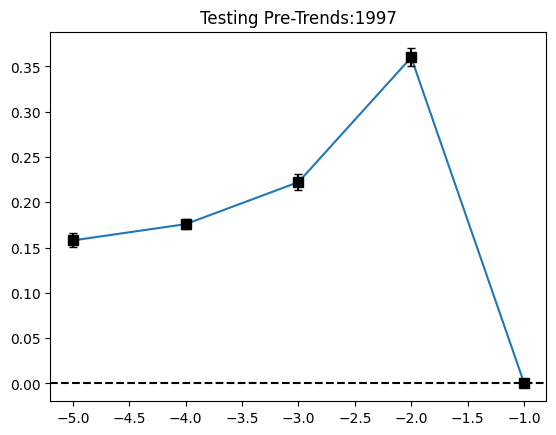

In [31]:
# Plotnine code to make plot for pre-treatment effects
pre_treat = all_years[(all_years["year"] < plot_year) & (all_years["treat_year"] != 2006)].copy()

#pre_treat["treat_year"] = pre_treat["treat_year"].replace(2006, "Never Implemented")

x = np.arange(1992-plot_year, 0, 1) 
plt.plot(x, pre_treat[pre_treat["treat_year"]==plot_year]["att"], label= "g = "+ str(plot_year))
mean_list = np.array(pre_treat[pre_treat["treat_year"]==plot_year]["att"])
ste_list = np.array(pre_treat[pre_treat["treat_year"]==plot_year]["std"])
print(mean_list)
print(ste_list)

for i in range(len(mean_list)):
    plt.errorbar(x=i + 1992 - plot_year, y=mean_list[i], yerr=ste_list[i], \
                 color="black", capsize=3, linestyle="None",\
                marker="s", markersize=7, mfc="black", mec="black")
#x = np.arange(-6, -1, 1) 
#plt.plot(x, pre_treat[pre_treat["treat_year"]==1998]["att"], label= "g = 1998")
#x = np.arange(-6, -1, 1) 
#plt.plot(x, pre_treat[pre_treat["treat_year"]==1999]["att"], label= "g = 1999")
plt.axhline(y = 0, color = 'k', linestyle = "dashed")  
plt.title("Testing Pre-Trends:" +str(plot_year) )
plt.show()

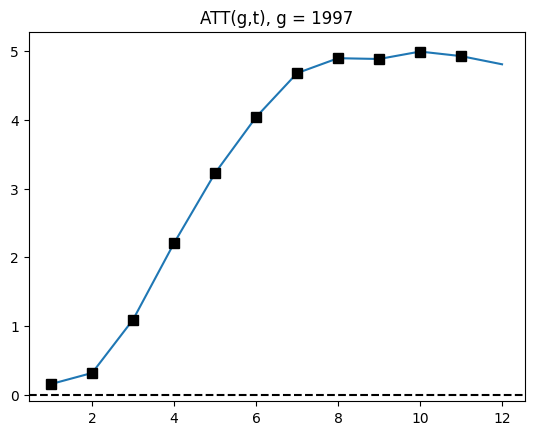

In [32]:
post_treat = all_years[(all_years["year"] >= plot_year) & (all_years["treat_year"] != 2006)].copy()

#post_treat["treat_year"] = post_treat["treat_year"].replace(2006, "Never Implemented")

x = np.arange(1, 2010-plot_year, 1) 
plt.plot(x, post_treat[post_treat["treat_year"]==plot_year]["att"], label= "g = " +str(plot_year))

mean_list = np.array(post_treat[post_treat["treat_year"]==plot_year]["att"])
ste_list = np.array(post_treat[post_treat["treat_year"]==plot_year]["std"])


for i in range(1,2009-plot_year ):
    plt.errorbar(x=i, y=mean_list[i-1], yerr=ste_list[i-1], \
                 color="black", capsize=3, linestyle="None",\
                marker="s", markersize=7, mfc="black", mec="black")

plt.axhline(y = 0, color = 'k', linestyle = "dashed")  
plt.title("ATT(g,t), g = " + str(plot_year))
plt.show()